## TODO Goal of the Project
The goal of this project is to create a product recommender system for Sephora based on customer ratings/reviews.  This will be an unsupervised machine learning problem to attempt to predict how customers will like a given product.  The approach will be to clean the data and perform some exploratory data analysis to get a high-level understanding of the data elements and the relationships between them. I will then create unsupervised learning models using collaborative filtering and NMF to predict ratings.  I will also create an unsupervised model using K-nearest neighbors to provide recommendations to Sephora customers about products they may enjoy based on their highest rated product. 

This project has been published to GitHub at ***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from scipy.sparse import coo_matrix, csr_matrix
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

## TODO Data Understanding

The dataset author collected review and product information for Sephora (a beauty and skin care retailer) via a Python scraper in March 2023.  

### Data Citation in APA Format

Inky, N. (2023). Sephora Products and Skincare Reviews. Version 1. [Data set]. Retrieved from https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews.

### Data Description

#### Users

The user dataset contains 1,094,411 rows and 18 columns, which I will narrow down to the following columns of interest for this project:

| Column | Data Type | Description |
| --- | --- | --- |
| author_id | string | Unique identifier for the user |
| rating | int | 1-5 rating for the product
| skin_tone | string | User's skin tone (e.g. fair, tan, etc.) |
| eye_color | string | User's eye color (e.g. brown, green, etc.) |
| skin_type | string | User's skin type (e.g. combination, oily, etc.) |
| hair_color | string | User's hair color (e.g. brown, auburn, etc.) |
| product_id | string | Unique alphanumeric identifier for the product |

#### Products

The product dataset contains 8494 rows and 27 columns, which I will narrow down to the following columns of interest for this project:

| Column | Data Type | Description |
| --- | --- | --- |
| product_id | string | Unique alphanumeric identifier for the product |
| product_name | string | Full name of the product |
| brand_name | string | Full name of the brand |
| price_usd | float | Price of the product in U.S. dollars |
| limited_edition | int | Indicates whether the product is a limited edition (1-yes, 0-no) |
| online_only | int | Indicates whether the product only available online (1-yes, 0-no) |
| sephora_exclusive | int | Indicates whether the product is exclusive to Sephora (1-yes, 0-no) |
| primary_category | string | First level of product categorization |

### Load the Data

#### Users and Ratings

I load the reviews data from the muliple CSV files provided by the dataset author and combine them together into a single dataframe.  I then separate that dataframe into two dataframes, one for the user's attributes noted above (e.g., eye color) and another for the ratings (i.e., author ID, product ID, and rating).

In [2]:
df1 = pd.read_csv('reviews_0-250.csv', index_col=0)
df2 = pd.read_csv('reviews_250-500.csv', index_col=0)
df3 = pd.read_csv('reviews_500-750.csv', index_col=0)
df4 = pd.read_csv('reviews_750-1250.csv', index_col=0)
df5 = pd.read_csv('reviews_1250-end.csv', index_col=0)

df_users = pd.concat([df1, df2, df3, df4, df5])
df_users.head()

,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1094411 entries, 0 to 49976
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   author_id                 1094411 non-null  object 
 1   rating                    1094411 non-null  int64  
 2   is_recommended            926423 non-null   float64
 3   helpfulness               532819 non-null   float64
 4   total_feedback_count      1094411 non-null  int64  
 5   total_neg_feedback_count  1094411 non-null  int64  
 6   total_pos_feedback_count  1094411 non-null  int64  
 7   submission_time           1094411 non-null  object 
 8   review_text               1092967 non-null  object 
 9   review_title              783757 non-null   object 
 10  skin_tone                 923872 non-null   object 
 11  eye_color                 884783 non-null   object 
 12  skin_type                 982854 non-null   object 
 13  hair_color                867643 n

In [4]:
df_ratings = df_users[['author_id', 'product_id', 'rating']]
df_users = df_users[['author_id', 'skin_tone', 'eye_color', 'skin_type', 'hair_color']]
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1094411 entries, 0 to 49976
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   author_id   1094411 non-null  object
 1   skin_tone   923872 non-null   object
 2   eye_color   884783 non-null   object
 3   skin_type   982854 non-null   object
 4   hair_color  867643 non-null   object
dtypes: object(5)
memory usage: 50.1+ MB


In [5]:
df_users.head()

,author_id,skin_tone,eye_color,skin_type,hair_color
0,1741593524,NaN,brown,dry,black
1,31423088263,NaN,NaN,NaN,NaN
2,5061282401,light,brown,dry,blonde
3,6083038851,NaN,brown,combination,black
4,47056667835,light,hazel,combination,NaN


In [6]:
df_ratings.head()

,author_id,product_id,rating
0,1741593524,P504322,5
1,31423088263,P420652,1
2,5061282401,P420652,5
3,6083038851,P420652,5
4,47056667835,P420652,5


#### Products
I now load the product dataset and filter to the columns of interest listed above.

In [7]:
df_products = pd.read_csv('product_info.csv')
df_products.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [8]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [9]:
df_products = df_products[['product_id', 'product_name', 
                           'brand_name',  'price_usd', 
                           'limited_edition', 'online_only', 
                           'sephora_exclusive', 'primary_category']]

In [10]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         8494 non-null   object 
 1   product_name       8494 non-null   object 
 2   brand_name         8494 non-null   object 
 3   price_usd          8494 non-null   float64
 4   limited_edition    8494 non-null   int64  
 5   online_only        8494 non-null   int64  
 6   sephora_exclusive  8494 non-null   int64  
 7   primary_category   8494 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 531.0+ KB


## TODO Data cleaning

### Data Types
The author id had some dummy values that were not numeric.  Casting the column to a number replaces the invalid values with NaNs.

In [11]:
df_ratings['author_id'] = pd.to_numeric(df_ratings['author_id'], errors='coerce')
df_users['author_id'] = pd.to_numeric(df_users['author_id'], errors='coerce')

### Handle missing values

#### Ratings

I removed the 60 rows with missing IDs (i.e., the author_ids that had invalid values when converting the column to an integer).

In [12]:
print(df_ratings.isna().sum())
max_na = max(df_ratings.isna().sum())
print(f"{max_na*100/len(df_ratings):.2f}% of rows have missing value")
print(df_ratings.shape)

author_id     64
product_id     0
rating         0
dtype: int64
0.01% of rows have missing value
(1094411, 3)


In [13]:
df_ratings = df_ratings.dropna()
print(df_ratings.isna().sum())
print(df_ratings.shape)

author_id     0
product_id    0
rating        0
dtype: int64
(1094347, 3)


#### Users

The user information has missing values in at least 20% of the rows.  However, each user can submit multiple reviews which may allow me to copy any missing values from another review submitted by that same user.

In [14]:
print(df_users.isna().sum())
max_na = max(df_users.isna().sum())
print(f"At least {max_na*100/len(df_users):.2f}% of rows have missing value")
print(df_users.shape)

author_id         64
skin_tone     170539
eye_color     209628
skin_type     111557
hair_color    226768
dtype: int64
At least 20.72% of rows have missing value
(1094411, 5)


In [15]:
''' Create a dictionary for each of the columns with missing values using the author_id as the key 
    and the first value for the column in question (e.g,. skin_tone) as the value in the dictionary.
    Then map the values from the dictionary into the rows missing those values.
'''

skin_tone_dict = df_users.dropna(subset=['skin_tone']).groupby('author_id')['skin_tone'].first().to_dict()
df_users['skin_tone'] = df_users['author_id'].map(skin_tone_dict).fillna(df_users['skin_tone'])

eye_color_dict = df_users.dropna(subset=['eye_color']).groupby('author_id')['eye_color'].first().to_dict()
df_users['eye_color'] = df_users['author_id'].map(skin_tone_dict).fillna(df_users['eye_color'])

skin_type_dict = df_users.dropna(subset=['skin_type']).groupby('author_id')['skin_type'].first().to_dict()
df_users['skin_type'] = df_users['author_id'].map(skin_tone_dict).fillna(df_users['skin_type'])

hair_color_dict = df_users.dropna(subset=['hair_color']).groupby('author_id')['hair_color'].first().to_dict()
df_users['hair_color'] = df_users['author_id'].map(skin_tone_dict).fillna(df_users['hair_color'])

I cut the percentage of rows with missing values almost in half.  Given the data set contains over one million users, I am just going to drop the rows that contain a missing value.  This left 969,071 rows in the dataset.  

In [16]:
print(df_users.isna().sum())
max_na = max(df_users.isna().sum())
print(f"At least {max_na*100/len(df_users):.2f}% of rows have missing value")
print(df_users.shape)

author_id         64
skin_tone     116184
eye_color     108376
skin_type      76126
hair_color    111621
dtype: int64
At least 10.62% of rows have missing value
(1094411, 5)


In [17]:
df_users = df_users.dropna()
print(df_users.isna().sum())
print(df_users.shape)

author_id     0
skin_tone     0
eye_color     0
skin_type     0
hair_color    0
dtype: int64
(978178, 5)


The users dataframe contains duplicate rows now that I populated the missing values, so I removed the duplicates.  This left 482,097 unique users with no missing attributes.

In [18]:
df_users = df_users.drop_duplicates()
print(df_users.shape)

(419679, 5)


#### Products

There are no missing values in the products dataset, which contains 8396 records.

In [19]:
print(df_products.isna().sum())
max_na = max(df_products.isna().sum())
print(f"{max_na*100/len(df_products):.2f}% of rows have missing value")
print(df_products.shape)

product_id           0
product_name         0
brand_name           0
price_usd            0
limited_edition      0
online_only          0
sephora_exclusive    0
primary_category     0
dtype: int64
0.00% of rows have missing value
(8494, 8)


## TODO EDA

Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (26 points)

 Go through the initial data cleaning and EDA and judge whether you need to collect more or different data. 

EDA Procedure Example:

Describe the factors or components that make up the dataset (The "factors" here are called "features" in the machine learning term. These factors are often columns in the tabulated data). For each factor, use a box-plot, scatter plot, histogram, etc., to describe the data distribution as appropriate.

Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated. You may use numeric or qualitative/graphical analysis for this step.

Determine if any data needs to be transformed. For example, if you're planning on using an SVM method for prediction, you may need to normalize or scale the data if there is a considerable difference in the range of the data.

Using your hypothesis, indicate if it's likely that you should transform data, such as using a log transform or other transformation of the dataset.

You should determine if your data has outliers or needs to be cleaned in any way. Are there missing data values for specific factors? How will you handle the data cleaning? Will you discard, interpolate or otherwise substitute data values?

If you believe that specific factors will be more important than others in your analysis, you should mention which and why. You will use this to confirm your intuitions in your final write-up.

### Distribution of Data

#### Ratings

The ratings are on a 1-5 scale and contains a majority of 5 ratings.  

<Axes: xlabel='rating', ylabel='Percent'>

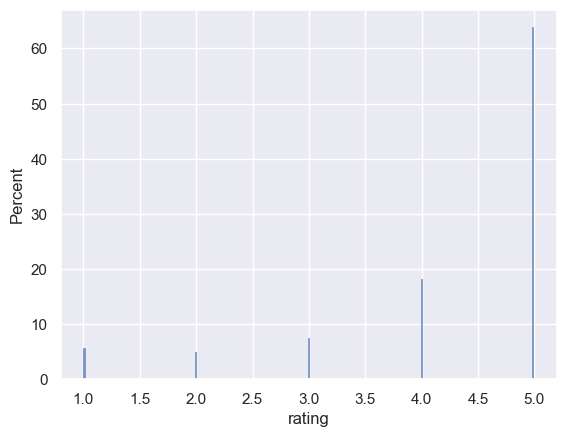

In [20]:
sns.histplot(data=df_ratings, x="rating", stat="percent")

#### Users

<Axes: xlabel='hair_color', ylabel='Percent'>

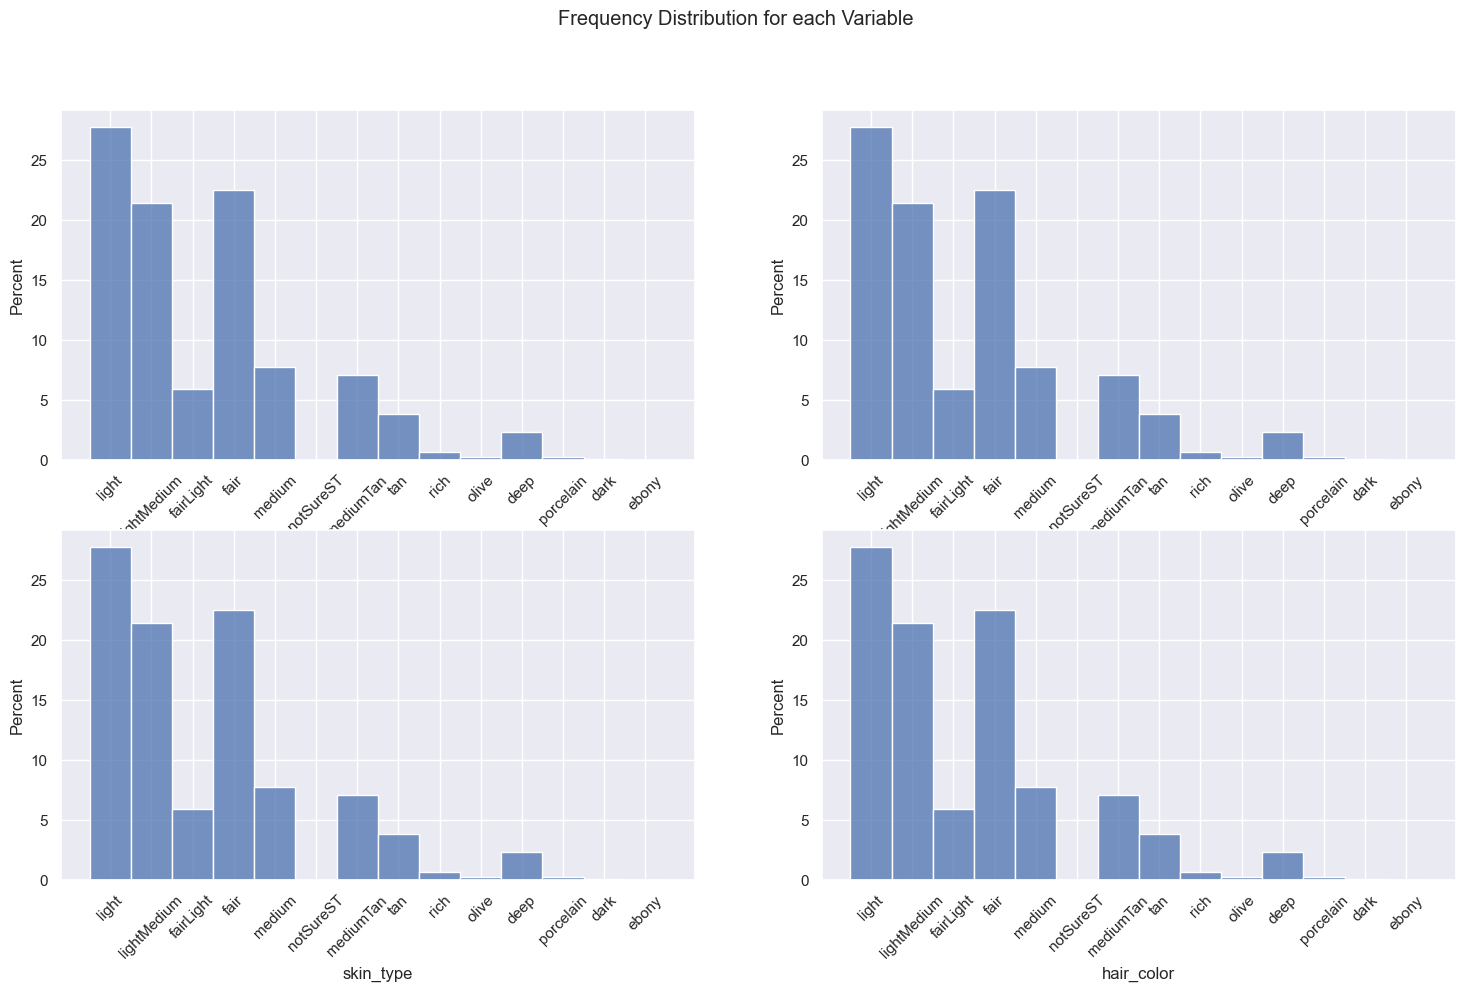

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Frequency Distribution for each Variable')
axes[0,0].tick_params(axis='x', labelrotation=45)
axes[0,1].tick_params(axis='x', labelrotation=45)
axes[1,0].tick_params(axis='x', labelrotation=45)
axes[1,1].tick_params(axis='x', labelrotation=45)

sns.histplot(ax=axes[0, 0], data=df_users, x='skin_tone', stat="percent")
sns.histplot(ax=axes[0, 1], data=df_users, x='eye_color', stat="percent")
sns.histplot(ax=axes[1, 0], data=df_users, x='skin_type', stat="percent")
sns.histplot(ax=axes[1, 1], data=df_users, x='hair_color', stat="percent")

#### Products

The binary factors (limited edition, online only, and sephora exclusive) have values of 0 and 1 and are heavily skewed toward the 0 (not) value.


<Axes: xlabel='sephora_exclusive', ylabel='Percent'>

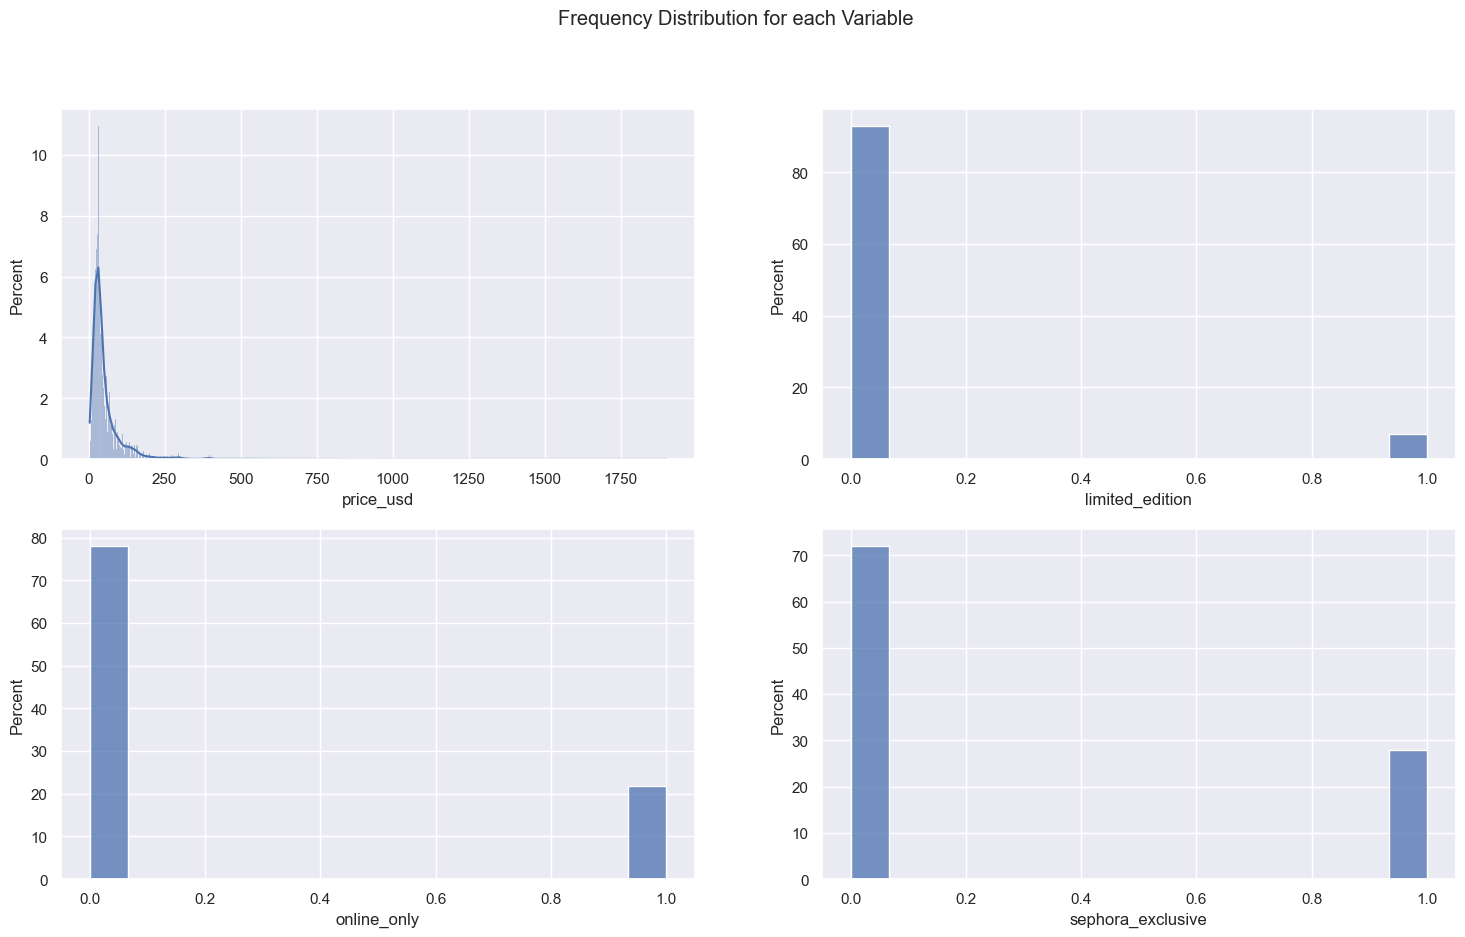

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Frequency Distribution for each Variable')

sns.histplot(ax=axes[0, 0], data=df_products, x='price_usd', kde=True, stat="percent")
sns.histplot(ax=axes[0, 1], data=df_products, x='limited_edition', stat="percent")
sns.histplot(ax=axes[1, 0], data=df_products, x='online_only', stat="percent")
sns.histplot(ax=axes[1, 1], data=df_products, x='sephora_exclusive', stat="percent")

##### Outliers in Price

Price has some significant outliers given the third quartile at \\$58 and a max value of \\$1900.  Removing outliers outside of 4 standard deviations will eliminate the significant outliers and leave 8113 rows in the dataset that follow a roughly normal distribution with a right skew.

<Axes: xlabel='price_usd'>

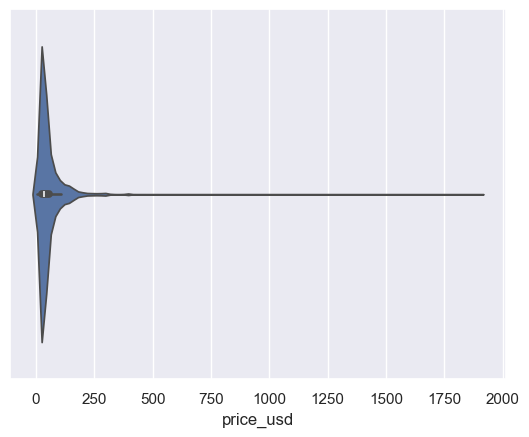

In [22]:
sns.violinplot(data=df_products, x='price_usd')

In [23]:
df_products['price_usd'].describe()

count    8494.000000
mean       51.655595
std        53.669234
min         3.000000
25%        25.000000
50%        35.000000
75%        58.000000
max      1900.000000
Name: price_usd, dtype: float64

In [24]:
total = len(df_products['price_usd'])
z_scores = np.abs((df_products['price_usd'] - df_products['price_usd'].mean()) / df_products['price_usd'].std())

for i in range(3,7):
    count = len(df_products['price_usd'][z_scores >  i])
    print(f"Outliers outside {i} standard deviations: {count} ({count*100/total:.2f}% of dataset)")


Outliers outside 3 standard deviations: 163 (1.92% of dataset)
Outliers outside 4 standard deviations: 98 (1.15% of dataset)
Outliers outside 5 standard deviations: 37 (0.44% of dataset)
Outliers outside 6 standard deviations: 31 (0.36% of dataset)


In [25]:
#Filter out rows with prices outside of 4 standard deviations from the mean
df_products = df_products[z_scores <= 4]
df_products['price_usd'].describe()

count    8396.000000
mean       48.209578
std        39.456292
min         3.000000
25%        25.000000
50%        35.000000
75%        58.000000
max       265.000000
Name: price_usd, dtype: float64

<Axes: xlabel='price_usd', ylabel='Percent'>

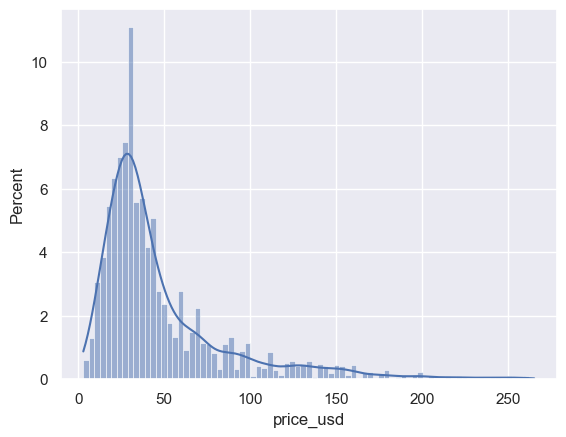

In [26]:
sns.histplot(data=df_products, x="price_usd", kde=True, stat="percent")

### Correlation Analysis

Correlation analysis of the numerical columns shows little to no correlation between the factors.  The strongest correlation is between the price and Sephora exclusive factors at a -0.14, which is still a weak correlation.

In [27]:
df_corr = df_products[['price_usd', 'limited_edition', 'online_only', 'sephora_exclusive']]

In [28]:
df_corr.corr()

,price_usd,limited_edition,online_only,sephora_exclusive
price_usd,1.000000,0.055505,0.084031,-0.163157
limited_edition,0.055505,1.000000,0.060368,0.065669
online_only,0.084031,0.060368,1.000000,-0.101281
sephora_exclusive,-0.163157,0.065669,-0.101281,1.000000


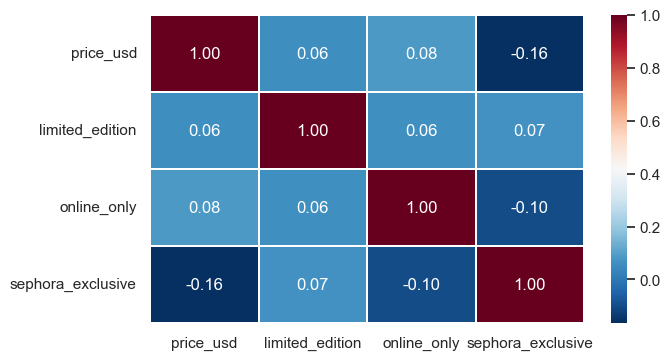

In [29]:
fig, ax = plt.subplots(figsize=(7, 4))  
#Plot a heatmap using correlation matrix
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", linewidth=.1, cmap="RdBu_r", ax=ax)
plt.show()

### Sync up Rating, User, and Product Datasets

I removed a number of rows from the user and product datasets, so I need to ensure that any rows remaining in the rating dataset have author_id and product_id values that exist in the user and product datasets, respectively.

In [30]:
df_ratings = df_ratings[df_ratings['author_id'].isin(df_users['author_id']) & df_ratings['product_id'].isin(df_products['product_id'])]

## Modeling

I first split the rating data into a training and test set.  I filtered the test set to ensure that the users and products were in the training set, which left me with   I then create a sparse matrices to hold the ratings for all users and products. 

In [31]:
x_train, x_test = train_test_split(df_ratings, test_size=.2, random_state=42)
x_train.shape

(778457, 3)

In [32]:
x_test.shape

(194615, 3)

In [33]:
x_test = x_test[x_test['author_id'].isin(x_train['author_id'])]
x_test.shape

(140664, 3)

In [34]:
x_test = x_test[x_test['product_id'].isin(x_train['product_id'])]
x_test.shape

(140659, 3)

In [35]:
df_ratings.head()

,author_id,product_id,rating
2,5.061282e+09,P420652,5
3,6.083039e+09,P420652,5
4,4.705667e+10,P420652,5
5,4.280257e+10,P420652,4
6,6.941884e+09,P420652,2


In [36]:
user_count = len(df_ratings['author_id'].unique())
prod_count = len(df_ratings['product_id'].unique())

# Map Ids to indices
user_id_to_idx = dict(zip(np.unique(df_ratings["author_id"]), list(range(user_count))))
prod_id_to_idx = dict(zip(np.unique(df_ratings["product_id"]), list(range(prod_count))))

# Map indices to IDs
prod_idx_to_id = dict(zip(list(range(prod_count)), np.unique(df_ratings["product_id"])))

user_index = [user_id_to_idx[i] for i in x_train['author_id']]
prod_index = [prod_id_to_idx[i] for i in x_train['product_id']]

rating_matrix_csr = csr_matrix((x_train["rating"], (prod_index, user_index)), shape=(prod_count, user_count))
rating_matrix_coo = np.array(coo_matrix((list(x_train['rating']), (user_index, prod_index)), shape=(user_count, prod_count)).toarray())


### TODO Predict Using Content or Collaborative???

TODO

In [37]:
def predict_from_sim(userID, prodID, sim_matrix, rat_matrix):
    #1. Get index of the provided user id
    index_userID = user_id_to_idx[userID]
    
    #2. Get all the user ratings for the user using index_userID
    ratings_index_userID = rat_matrix[index_userID]
            
    #3. Get index of the provided product id
    index_prodID = prod_id_to_idx[prodID]
            
    #4. Get all the similarity scores using index_prodID
    prod_sims = sim_matrix[index_prodID] 
            
    #5. Take the **averaged** dot product.        
    valid_ratings = (ratings_index_userID != 0)
    
    num = np.dot(ratings_index_userID, prod_sims)
    den = np.dot(prod_sims, valid_ratings)
    return num / den 
    
def predict(sim_matrix, rat_matrix):
    test_preds = []
    for i in range(len(x_test)):
        userID = x_test.iloc[i]['author_id']
        prodID = x_test.iloc[i]['product_id']
        test_preds.append(predict_from_sim(userID, prodID, sim_matrix, rat_matrix))
    return np.array(test_preds)
              
def cossim(xr):    
    #Algorithm:
    #1. Compute **averaged** product ratings for all users (prod_ratings_allUsers)
    #Calcs mean of each row
    prod_ratings_allUsers = xr.sum(axis=1) / np.count_nonzero(xr, axis=1)
    
    #2. Create a sparse matrix for operating cosine on its values:
    prod_ratings_array = np.repeat(np.expand_dims(prod_ratings_allUsers, axis=1), xr.shape[1], axis=1)

    #3. Take care of all the zero ratings (missing value/itentionally we don't know):
    prod_ratings_array_adjusted = xr + (xr==0)*prod_ratings_array - prod_ratings_array
    
    #4. Average all the ratings: divide by its magnitude!
    rating_avg = prod_ratings_array_adjusted/np.sqrt((prod_ratings_array_adjusted**2).sum(axis=0))
   
    #5. Put a Boundary check # 1: since dividing by magnitude may produce inf, zeros, etc. Set nans to 0.
    rating_avg = np.nan_to_num(rating_avg, 0)
    
    #6. Perform an item-item cosine similarity using: np.dot(matrix.T, matrix)
    similarity = np.dot(rating_avg.T, rating_avg)
    
    #7. Put a Boundary check # 2: Covariance/correlation values for np.dot([M.T, M]) matrix should have 
    #   diagonal set to 1. 
    np.fill_diagonal(similarity, 1) 
        
    #8. Normalized Cosine Formula:
    similarity = np.multiply(similarity, 0.5) + 0.5 
    
    return similarity

def jacsim(Xr): 
    # Return a sim matrix by calculating item-item similarity for all pairs of items using Jaccard similarity
    # Jaccard Similarity: J(A, B) = |A∩B| / |A∪B| 
    n = Xr.shape[1]
    maxr = int(Xr.max())
    
    #This is only used for the non-transformed case
    if maxr>1:
        nz_inter = np.zeros((n,n)).astype(int)
        for i in range(1, maxr+1):
            csr = csr_matrix((Xr==i).astype(int))
            nz_inter = nz_inter + np.array(csr.T.dot(csr).toarray()).astype(int)    
    else:
        # Convert Xr into a CSR format
        csr0 = csr_matrix((Xr>0).astype(int))

        # Take the dot product
        nz_inter = np.array(csr0.T.dot(csr0).toarray()).astype(int)   
    
    # Formula JS:
    A = (Xr>0).astype(bool)
    rowsum = A.sum(axis=0)
    rsumtile = np.repeat(rowsum.reshape((n,1)),n,axis=1)   
    union = rsumtile.T + rsumtile - nz_inter
    
    # Perform the two boundary checks:-
    #  - since dividing by magnitude may produce inf, zeros, etc. Set nans to 0.
    #  - Covariance/correlation values for np.dot([M.T, M]) matrix should have 
    #    diagonal set to 1.

    union = np.nan_to_num(union, 0)
    intersection = np.nan_to_num(nz_inter, 0)
    
    similarity = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union!=0)
    np.fill_diagonal(similarity, 1) 
    return similarity

def rmse(yp):
    yp[np.isnan(yp)]=3 #In case there is nan values in prediction, it will impute to 3.
    yt=np.array(x_test['rating'])
    return np.sqrt(((yt-yp)**2).mean())

In [38]:
sim_matrix = cossim(rating_matrix_coo)

In [39]:
yp = predict(sim_matrix, rating_matrix_coo)
print(rmse(yp))

1.0881795275262927


In [40]:
jacsim_matrix = jacsim(rating_matrix_coo)

In [41]:
yp = predict(jacsim_matrix, rating_matrix_coo)
print(rmse(yp))

1.1191216782108373


### TODO Predict Using NMF

TODO Non-Negative Matrix Factorization (NMF) 

In [42]:
def predict(all_preds):
    """
    Predict ratings in the test data. Returns predicted rating in a numpy array of size (# of rows in testdata,)
    """
    test_preds = []
    for i, row in x_test.iterrows():
        index_userID = user_id_to_idx[row['author_id']] 
        index_prodID = prod_id_to_idx[row['product_id']] 
        rating = all_preds[index_prodID][index_userID]
        test_preds.append(rating)
    return np.array(test_preds)

In [43]:
model = NMF(n_components=5)
W = model.fit_transform(rating_matrix_csr) 
H = model.components_
pred_ratings = np.dot(W, H)

y_pred = predict(pred_ratings)
rmse(y_pred)

4.328119372422528

### TODO: Recommendation System Using K-Nearest Neighbors

Now that I've implemented rating prediction, I wanted to enhance the solution by building a recommender system.  I usesd k-nearest neighbors to return the recommendations for a given user.  The recommendations are centered around the user's favorite (highest-rated) product.

In [44]:
def find_similar_products(target_prod_id, rating_matrix, k, metric='cosine'):
    neighbor_ids = []
    
    product_to_match = prod_id_to_idx[target_prod_id]
    prod_vector = rating_matrix[product_to_match]
    k += 1  #Increase by one because the target product will be included by NearestNeighbors
    
    kNN = NearestNeighbors(n_neighbors=k, metric=metric)
    kNN.fit(rating_matrix)
    neighbor = kNN.kneighbors(prod_vector, return_distance=False)

    for i in range(0, k):
        n = neighbor.item(i)
        neighbor_ids.append(prod_idx_to_id[n])

    neighbor_ids.pop(0)  # Remove the target product from the final list
    return neighbor_ids


In [45]:
def recommend_prods_for_user(user_id, rating_matrix, user_id_to_idx, prod_id_to_idx, prod_idx_to_id, metric, k=5):
    df = df_ratings[df_ratings['author_id'] == user_id]

    # Find the user's highest-rated product and k-nearest neighbors
    fav_prod_id = df[df['rating'] == max(df['rating'])]['product_id'].iloc[0]
    similar_ids = find_similar_products(fav_prod_id, rating_matrix, k, metric=metric)

    # Map product IDs to product names
    prod_names = dict(zip(df_products['product_id'], df_products['product_name']))

    print(f"Since you liked {prod_names[fav_prod_id]}, you might also like:")

    for i in similar_ids:
        if i in prod_names:
            print(f"* {prod_names[i]}")


In [46]:
user_id = 6047267707  
recommend_prods_for_user(user_id, rating_matrix_csr, user_id_to_idx, prod_id_to_idx, prod_idx_to_id, metric='cosine')

Since you liked Greek Yoghurt Foaming Cream Cleanser, you might also like:
* Extra Illuminating Moisture Balm
* Greek Yoghurt Nourishing Probiotic Gel-Cream
* POWER Recharging Night Pressed Serum
* Pep-Start Eye Cream
* Advanced Night Repair Synchronized Multi-Recovery Complex Duo


In [47]:
user_id = 6047267707  
recommend_prods_for_user(user_id, rating_matrix_csr, user_id_to_idx, prod_id_to_idx, prod_idx_to_id, metric='euclidean')

Since you liked Greek Yoghurt Foaming Cream Cleanser, you might also like:
* ExfoliKate All Over Glow Kit
* Big Break Soap Set
* 3 Step Intro Kit Type II
* Break from the Burnout Skin Wellness Set
* Glow Facial Set


## Results and Analysis

Perform Analysis Using Unsupervised Learning Models of your Choice, Present Discussion, and Conclusions (70 points)

Model building and training may depend on their data type(s) and task type(s). Depending on your project, you may have one model or more. Generally, it is deemed a higher quality project if you compare multiple models and show your understanding of why specific models work better than the other or what limitations or cautions specific models may have. When using multiple models, at least one of them should be an unsupervised approach. 

 For machine learning models, another recommendation is to show enough effort on the hyperparameter optimization.

 If your project involves making a web app (not required), you can include the demo.

## Model Comparison

### Improving Performance Through Hypertuning Parameters

## Discussion and Conclusion

### Learnings and Takeaways

### Things that Did Not Go as Planned

TODO The NMF prediction did not perform as well as collaborative 

This could be due to the sparseness of the ratings in the training set (i.e., users did not rate all movies). Increasing the number of components or imputing missing values to make the matrix less sparse could improve the RMSE. Note that when imputing missing values, we would want to use something other than zero (e.g., use the user's average rating) because filling in missing values as zero falls outside of the "valid" ratings of 1-5.

### Ways to Improve

## References

1. https://www.geeksforgeeks.org/recommendation-system-in-python/
2. https://scikit-learn.org/stable/modules/neighbors.html
